### PEQUENO TESTE 04

Este teste aborta a aplicação do Método Nealder Meader Simplex para um
problema otimização sem derivada. O problema de otimização abordado é o
seguinte:

    Minimizar f(x) = 5*sqrt(9*x1^2 + 16*x2^2) se x1 >= |x2|
                   = 9*x1 + 16*|x2| se 0 < x1 < |x2|
                   = 9*x1 + 16*|x2| - x1^9 se x1 <= 0

Você deverá implementar o cálculo dos pontos resultantes das operações de
reflexão (xr), expansão (xe) e contração (xc) do método Nealder Meader Simplex.
Basta implementar a fórmula do cálculo desses pontos nas linhas 97, 104 e 130,
respectivamente.

In [8]:
import numpy as np
from matplotlib import pyplot as plt

# Definição da função objetivo
def func(x):
    """ Função Wolfe. Referência:

        Zowe, J. "Nondifferentiable optimization." Computational 
        Mathematical Programming. Berlin, Heidelberg: Springer Berlin 
        Heidelberg, 1985. 323-356. """
    x1, x2 = x[0], x[1]

    if x1 >= np.abs(x2):
        return 5*np.sqrt((9*x1**2 + 16*x2**2))
    elif 0 < x1 and x1 < np.abs(x2):
        return 9*x1 + 16*np.abs(x2)
    elif x1 <= 0:
        return 9*x1 + 16*np.abs(x2) - x1**9

O Método de Nelder-Mead (o gpt chamou ele de simplex???) é um algoritmo heurístico para otimização de funções sem derivadas. Ele utiliza um simplex, que em n dimensões é um polígono com n+1 vértices.

O algoritmo abaixo pode ser divido em diferentes etapas:

Reflexão (xr): tenta melhorar o pior ponto refletindo-o em torno do centroide dos outros pontos.

Expansão (xe): se a reflexão for muito boa, tenta ir além.

Contração (xc): se a reflexão não for boa, tenta se mover para dentro do simplex.

Encolhimento (shrink): se tudo falhar, reduz todo o simplex em direção ao melhor ponto.

Anotações:
- n usa derivadas
- pode ficar preso em mínimos locais, lento


Resultado: [-9.39300974e-01  3.45524028e-17]
Valor da função: -7.884537516723112
Avaliações: 2433
Iterações: 500


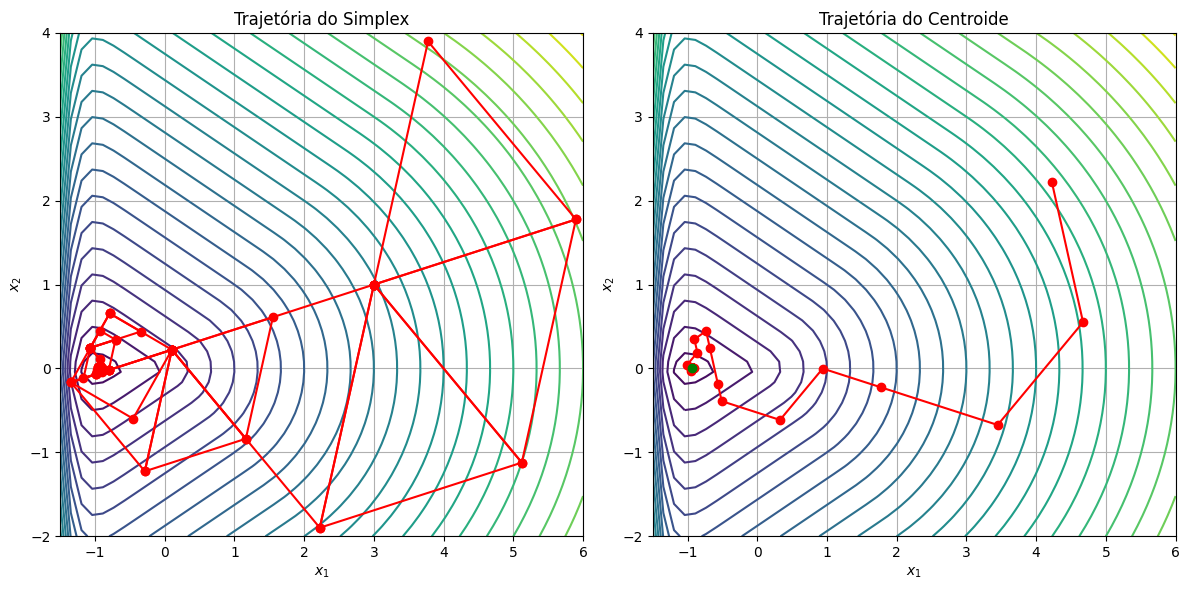

In [9]:
# Parâmetros Iniciais
ponto_inicial = [3., 1.]
ponto_inicial = np.array(ponto_inicial)
max_iter = 500

# Variáveis do método
num_variaveis = ponto_inicial.size
num_pontos = num_variaveis + 1
alpha = 1.0 # Coeficiente de reflexão
gamma = 2.0 # Coeficiente de expansão
beta = 0.5 # Coeficiente de contração

# Metodologia de inicialização do simplex conforme seguinte referência:
# Spendley, W. G. R. F. R., George R. Hext, and Francis R. Himsworth. 
# "Sequential application of simplex designs in optimisation and evolutionary 
# operation." Technometrics 4.4 (1962): 441-461.
simplex_inicial = [ponto_inicial]
a = num_pontos
n = num_variaveis
p = a/(n*np.sqrt(2))*(np.sqrt(n+1) + n - 1)
q = a/(n*np.sqrt(2))*(np.sqrt(n+1) - 1)
u = np.eye(n)
for i in range(num_variaveis):
    ponto = ponto_inicial.copy()
    ponto += p*u[i, :]
    for j in range(n):
        if j != i:
            ponto += q*u[j, :]
    simplex_inicial.append(ponto)

# Inicialização das variáveis principais
simplex = np.array(simplex_inicial)
valores = [func(point) for point in simplex]
iteracao = 0
avaliacoes = 3

# Registro da história do simplex
xhist = [np.mean(simplex, axis=0)]
fxhist = [valores[0]]
simplexhist = [simplex.copy()]

# Critério de parada: número de iterações
while iteracao < max_iter:

    # Ordenar o simplex: o primeiro ponto é o melhor e o último é o pior
    ordem = np.argsort(valores)
    simplex = simplex[ordem]
    valores = [func(ponto) for ponto in simplex]
    avaliacoes += 3

    # Nomes dos pontos
    xb, fb = simplex[0], valores[0] # Melhor ponto
    xs, fs = simplex[-2], valores[-2] # Segundo pior ponto
    xw, fw = simplex[-1], valores[-1] # Pior ponto

    # Calcular o centro do simplex, excluindo o pior ponto
    centroide = np.mean(simplex[:-1], axis=0)
    xh = centroide # Um nome mais curto para o centróide

    # Primeira tentativa: reflexão (xr)
    xr = xh + alpha * (xh - xw)
    fr = func(xr)

    # Caso a reflexão seja melhor que o melhor ponto do simplex
    if fr < fb:

        # Segunda tentativa: expansão (xe)
        xe = xh + gamma * (xr - xh)
        fe = func(xe)

        # Se a expansão for melhor ainda que a reflexão, fica com a expansão
        if fe < fr:
            simplex[-1] = xe
            valores[-1] = fe
        
        # Se a expansão não for melhor que a reflexão, fica com a reflexão
        else:
            simplex[-1] = xr
            valores[-1] = fr

    # Caso a reflexão não seja melhor que o melhor ponto do simplex,
    # mas seja pelo menos melhor que o segundo pior ponto
    elif fb <= fr < fs:

        # Fica com a reflexão
        simplex[-1] = xr
        valores[-1] = fr

    # Caso a reflexão seja pior que o segundo pior ponto, mas melhor que o pior 
    # ponto
    elif fs <= fr < fw:
            
        # Terceira tentativa: contração (xc)
        xc = xh + beta * (xw - xh)
        fc = func(xc)
    
        # Se a contração for melhor que o ponto da reflexão, substitui o pior
        # ponto pelo ponto da contração
        if fc < fr:
            simplex[-1] = xc
            valores[-1] = fc

        # Se a contração não for melhor que o ponto da reflexão, substitui o
        # pior ponto pelo ponto da reflexão
        else:
            simplex[-1] = xr
            valores[-1] = fr

    # Caso a reflexão seja pior que o pior ponto
    else:

        # Encolhimento do simplex
        for i in range(1, num_pontos):
            simplex[i] = (simplex[i] + xb)/2
            valores[i] = func(simplex[i])
            avaliacoes += 1

    # Registros
    iteracao += 1
    xhist.append(np.mean(simplex, axis=0))
    fxhist.append(valores[0])
    simplexhist.append(simplex.copy())

# Solução final é o melhor ponto do simplex final
x = simplex[0]
fx = func(simplex[0])

# Conversão para numpy array
simplexhist = np.array(simplexhist)
xhist = np.array(xhist)
fxhist = np.array(fxhist)

# Exibe resultados
print(f"Resultado: {x}")
print(f"Valor da função: {fx}")
print(f"Avaliações: {avaliacoes}")
print(f"Iterações: {iteracao}")

# Malha para plotar contorno
x1, x2 = np.meshgrid(np.linspace(-1.5, 6),
                     np.linspace(-2, 4))

# Avalia função para plotar contorno
f = np.zeros(x1.shape)
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        f[i, j] = func([x1[i, j], x2[i, j]])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Primeira figura: trajetória do simplex
axs[0].contour(x1, x2, f, levels=30)
for n in range(simplexhist.shape[0]-46):
    axs[0].plot(simplexhist[n, :, 0].tolist() + [simplexhist[n, 0, 0]],
                simplexhist[n, :, 1].tolist() + [simplexhist[n, 0, 1]], '-or')
axs[0].set_xlabel(r'$x_1$')
axs[0].set_ylabel(r'$x_2$')
axs[0].set_title('Trajetória do Simplex')
axs[0].grid()

# Segunda figura: trajetória do ponto médio do simplex
axs[1].contour(x1, x2, f, levels=30)
xhist = np.array(xhist)
axs[1].plot(xhist[:, 0], xhist[:, 1], '-or')
axs[1].plot(x[0], x[1], 'og')
axs[1].set_xlabel(r'$x_1$')
axs[1].set_ylabel(r'$x_2$')
axs[1].set_title('Trajetória do Centroide')
axs[1].grid()

plt.tight_layout()
plt.show()

O resultado pareceu insatisfatório com um altíssimo número de avaliações e aparentemente estourando o número de iterações definido como 500 e não encontrando um resultado ótimo. 
O Nelder-Mead ainda estava tentando melhorar o resultado quando foi interrompido. 

O motivo pra isso eu realmente vou ficar devendo no momento devido a correria dessa semana (das próximas vai melhoraar prometo!!). Na revisão depois eu pergunto ou descubro sozinho...